<h1>Hypothesis: "Antartic locations with subterrainian lake will have flatter surafce ice slopes"</h1>

basemap: http://quantarctica.tpac.org.au/quantarctica/Quantarctica3/Basemap/

lakes: https://www.npolar.no/quantarctica/#toggle-id-15

dem: https://www.pgc.umn.edu/data/rema/

bedmap: https://www.bas.ac.uk/project/bedmap-2/#data

In [2]:
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as xrio
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from shapely.geometry import shape
from raster_tools import surface, Raster, zonal
import cartopy.crs as ccrs
import numpy as np

c:\Users\aster\anaconda3\envs\rstools39\lib\site-packages\pyogrio\core.py:23: RuntimeWarning: Could not detect GDAL data files.  Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()
c:\Users\aster\anaconda3\envs\rstools39\lib\site-packages\fiona\env.py:662: RuntimeWarning: Cannot find header.dxf (GDAL_DATA is not defined)
  elif GDALDataFinder().find_file("header.dxf"):
Cannot find header.dxf (GDAL_DATA is not defined)


<h3>Lake Locations</h3>

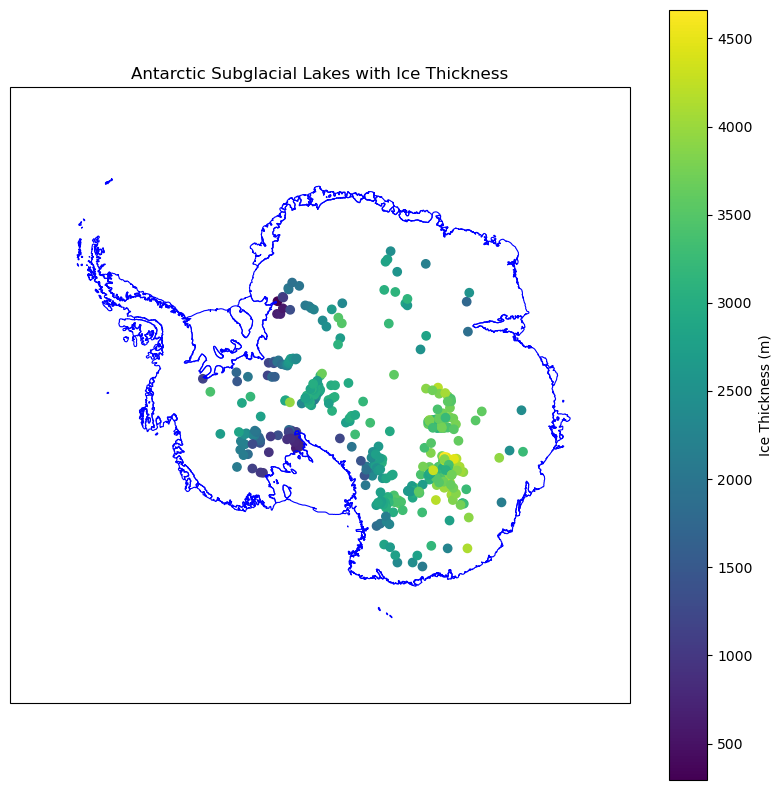

In [3]:
# Load Antarctic subglacial lakes
lakes = pd.read_csv('data/lakes/subglacial_lakes_2012update.csv', encoding='latin1')
lakes.rename(columns={'Lat.         oN': 'Latitude', 'Lon.       oE': 'Longitude'}, inplace=True)
lakes_gdf = gpd.GeoDataFrame(lakes, geometry=gpd.points_from_xy(lakes['Longitude'], lakes['Latitude']))

# Set lakes CRS to WGS84 (EPSG:4326) and transform to Antarctic Polar Stereographic (EPSG:3031)
lakes_gdf.set_crs(epsg=4326, inplace=True)
lakes_gdf = lakes_gdf.to_crs(epsg=3031)

# Load Antarctic shapefile and transform to EPSG:3031
# world = gpd.read_file('data/antarc241115/ANTARC241115.shp')
world = gpd.read_file('data\coastline\ADD_Coastline_low_res_polygon.shp')
world = world.to_crs(epsg=3031)

# Plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.SouthPolarStereo()})
world.boundary.plot(ax=ax, transform=ccrs.SouthPolarStereo(), linewidth=0.8, color='blue')
lakes_gdf.plot(ax=ax, cmap='viridis', column='Ice thickness m', legend=True, 
               legend_kwds={'label': "Ice Thickness (m)"}, transform=ccrs.SouthPolarStereo())

# Adjust map extent if needed
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())  # Adjust bounds for rotation

plt.title("Antarctic Subglacial Lakes with Ice Thickness")
plt.show()

<h3>Ice Thickness</h3>

In [3]:
thickness_tif_path = 'data\\bedmap2_tiff\\bedmap2_thickness.tif'
thickness_xr = xrio.open_rasterio(thickness_tif_path)

thickness_xr

<xarray.DataArray (band: 1, y: 6667, x: 6667)> Size: 89MB
[44448889 values with dtype=int16]
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 53kB -3.333e+06 -3.332e+06 ... 3.332e+06 3.333e+06
  * y            (y) float64 53kB 3.333e+06 3.332e+06 ... -3.332e+06 -3.333e+06
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  4621
    STATISTICS_MEAN:     1926.6438367784
    STATISTICS_MINIMUM:  0
    STATISTICS_STDDEV:   1052.6332469716
    _FillValue:          32767
    scale_factor:        1.0
    add_offset:          0.0

In [4]:
# thickness_xr_masked = thickness_xr.where(thickness_xr != 32767)

# thickness_xr_masked.plot(figsize=(10, 10), cmap='viridis')
# plt.title("Ice Thickness (m)")
# plt.show()

<h5>Update Lake GDF to have thicknesses</h5>

In [5]:
def add_ice_thickness_to_lakes(lakes_gdf, thickness_xr):
    """
    Adds ice thickness values from thickness_xr to lakes_gdf based on lake coordinates.
    Args:
    - lakes_gdf (GeoDataFrame): DataFrame containing lake locations and metadata.
    - thickness_xr (xarray.DataArray): The ice thickness xarray containing ice thickness data.
    
    Returns:
    - lakes_gdf (GeoDataFrame): The lakes GeoDataFrame with an additional 'ice_thickness' column.
    """
    # Create a new column 'ice_thickness' in lakes_gdf
    lakes_gdf['ice_thickness'] = [
        thickness_at_lake(thickness_xr, point)  # Get ice thickness at lake location
        for point in lakes_gdf.geometry
    ]
    
    return lakes_gdf

def thickness_at_lake(thickness_xr, point):
    """
    Extract the ice thickness value at a specific lake location.
    Args:
    - thickness_xr (xarray.DataArray): The ice thickness data
    - point (shapely.geometry.point.Point): The lake point geometry
    
    Returns:
    - thickness_value (float): Ice thickness at the lake location
    """
    # Extract coordinates of the lake point
    x, y = point.x, point.y
    
    # Extract ice thickness at the lake location (nearest neighbor interpolation)
    thickness_value = thickness_xr.sel(x=x, y=y, method='nearest')
    
    return thickness_value.item()  # Convert to scalar value

# Call the function to add ice thickness to lakes_gdf
lakes_gdf = add_ice_thickness_to_lakes(lakes_gdf, thickness_xr)

# Check the results
print(lakes_gdf[['Name', 'ice_thickness']].head())

              Name  ice_thickness
0  Sovetskaya Lake           3919
1      Lake Vostok           3303
2           SPRI-3           3474
3           SPRI-4           2344
4           SPRI-5           3729


In [6]:
lakes_gdf = lakes_gdf.drop(columns=["Ice thickness m"])
lakes_gdf

,Tally,Name,Latitude,Longitude,Length m,Width m,Depth m,Area km2,Volume km3,References,geometry,ice_thickness
0,1,Sovetskaya Lake,-78.100,88.500,75000,35000.0,NaN,1600.0,NaN,Located beneath Sovetskaya Station. The first ...,POINT (1296999.561 33963.129),3919
1,2,Lake Vostok,-78.150,104.500,280000,44000.0,1067.0,14000.0,5400.0,Included in the first inventory of Oswald and ...,POINT (1250803.318 -323479.733),3303
2,3,SPRI-3,-76.570,124.800,5000,NaN,NaN,NaN,NaN,Oswald and Robin (1973),POINT (1203517.434 -836466.407),3474
3,4,SPRI-4,-73.280,157.280,3500,NaN,NaN,NaN,NaN,Oswald and Robin (1973),POINT (706469.226 -1687214.515),2344
4,5,SPRI-5,-77.200,119.270,10000,NaN,NaN,NaN,NaN,Oswald and Robin (1973),POINT (1218054.666 -682702.029),3729
...,...,...,...,...,...,...,...,...,...,...,...,...
374,375,R13Ea_8,-75.981,106.045,3500,NaN,NaN,NaN,NaN,Wright et al. (2012),POINT (1470914.122 -423028.361),3474
375,376,R15Ea_4,-74.084,100.818,1800,NaN,NaN,NaN,NaN,Wright et al. (2012),POINT (1709145.571 -326593.471),3513
376,377,Site A,-67.800,112.540,NaN,NaN,NaN,NaN,NaN,"N. Young (personal comm.), drained followed by...",POINT (2255000.417 -935896.682),1818
377,378,Site B,-67.870,113.530,NaN,NaN,NaN,NaN,NaN,"N. Young (personal comm.), filling site, near ...",POINT (2231263.202 -971570.334),1549


<h3>Calculate Slope From DEM</h3>

In [7]:
dem_path = 'data\\rema_mosaic_500m_v2.0_filled_cop30\\rema_mosaic_500m_v2.0_filled_cop30_dem.tif'

dem_xr = xrio.open_rasterio(dem_path)
dem_xr

<xarray.DataArray (band: 1, y: 11686, x: 10902)> Size: 510MB
[127400772 values with dtype=float32]
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 87kB -2.7e+06 -2.7e+06 ... 2.75e+06 2.75e+06
  * y            (y) float64 93kB 3.342e+06 3.342e+06 ... -2.5e+06 -2.5e+06
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999.0
    scale_factor:   1.0
    add_offset:     0.0

In [8]:
slp = surface.slope(
    dem_path, degrees=False
)

slp

<raster_tools.Raster (crs='EPSG:3031', masked=True)>
<xarray.DataArray 'raster' (band: 1, y: 11686, x: 10902)> Size: 1GB
dask.array<where, shape=(1, 11686, 10902), dtype=float64, chunksize=(1, 5792, 5792), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 87kB -2.7e+06 -2.7e+06 ... 2.75e+06 2.75e+06
  * y            (y) float64 93kB 3.342e+06 3.342e+06 ... -2.5e+06 -2.5e+06
    spatial_ref  int32 4B 0
Attributes:
    _FillValue:  -999999.0

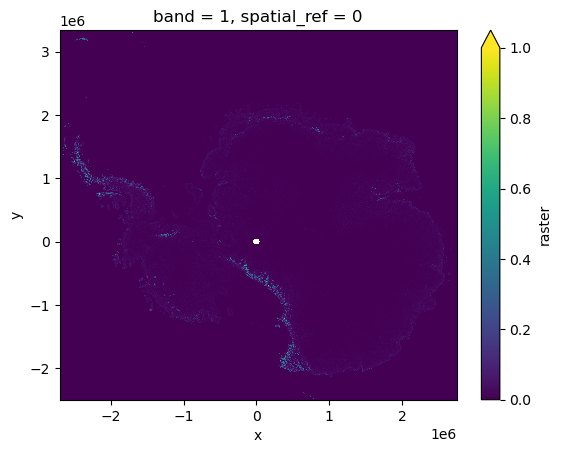

In [9]:
slp.plot(vmin=0, vmax=1)

plt.show()

<h3>Analysis</h3>

<h4>Slope Values at Lake Locations</h4>

In [1]:
lake_coords = np.array([lakes_gdf.geometry.x, lakes_gdf.geometry.y]).T

lake_coords

NameError: name 'np' is not defined

In [11]:
print(dir(slp))

['_HANDLED_TYPES', '__abs__', '__add__', '__and__', '__array__', '__array_priority__', '__array_ufunc__', '__class__', '__delattr__', '__dir__', '__divmod__', '__doc__', '__eq__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__iadd__', '__iand__', '__ifloordiv__', '__ilshift__', '__imatmul__', '__imod__', '__imul__', '__init__', '__init_subclass__', '__invert__', '__ior__', '__ipow__', '__irshift__', '__isub__', '__itruediv__', '__ixor__', '__le__', '__lshift__', '__lt__', '__matmul__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__or__', '__pos__', '__pow__', '__radd__', '__rand__', '__rdivmod__', '__reduce__', '__reduce_ex__', '__repr__', '__rfloordiv__', '__rlshift__', '__rmatmul__', '__rmod__', '__rmul__', '__ror__', '__rpow__', '__rrshift__', '__rshift__', '__rsub__', '__rtruediv__', '__rxor__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__sub__', '__subclasshook__', '__truediv__', '__xor__', '_build_reduce_

In [12]:
# Extract raster data and affine transform
slope_array = slp.to_numpy()  # Convert raster to a NumPy array
affine_transform = slp.affine  # Affine transform for mapping coordinates
nodata_value = slp.null_value  # No-data value

In [13]:
# Function to map geographic coordinates to array indices
def coords_to_indices(x, y, transform):
    col, row = ~transform * (x, y)
    return int(row), int(col)

# Extract slope values for each lake point
lake_slopes = []
for geom in lakes_gdf.geometry:
    row, col = coords_to_indices(geom.x, geom.y, affine_transform)
    if 0 <= row < slope_array.shape[1] and 0 <= col < slope_array.shape[2]:  # Check bounds
        value = slope_array[0, row, col]  # Access the value from the raster
        lake_slopes.append(value if value != nodata_value else None)
    else:
        lake_slopes.append(None)  # Out-of-bounds points

# Add extracted values to GeoDataFrame
lakes_gdf["slope"] = lake_slopes


In [14]:
lakes_gdf

,Tally,Name,Latitude,Longitude,Length m,Width m,Depth m,Area km2,Volume km3,References,geometry,ice_thickness,slope
0,1,Sovetskaya Lake,-78.100,88.500,75000,35000.0,NaN,1600.0,NaN,Located beneath Sovetskaya Station. The first ...,POINT (1296999.561 33963.129),3919,0.086016
1,2,Lake Vostok,-78.150,104.500,280000,44000.0,1067.0,14000.0,5400.0,Included in the first inventory of Oswald and ...,POINT (1250803.318 -323479.733),3303,0.114682
2,3,SPRI-3,-76.570,124.800,5000,NaN,NaN,NaN,NaN,Oswald and Robin (1973),POINT (1203517.434 -836466.407),3474,0.029392
3,4,SPRI-4,-73.280,157.280,3500,NaN,NaN,NaN,NaN,Oswald and Robin (1973),POINT (706469.226 -1687214.515),2344,0.227904
4,5,SPRI-5,-77.200,119.270,10000,NaN,NaN,NaN,NaN,Oswald and Robin (1973),POINT (1218054.666 -682702.029),3729,0.057291
...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,375,R13Ea_8,-75.981,106.045,3500,NaN,NaN,NaN,NaN,Wright et al. (2012),POINT (1470914.122 -423028.361),3474,0.095858
375,376,R15Ea_4,-74.084,100.818,1800,NaN,NaN,NaN,NaN,Wright et al. (2012),POINT (1709145.571 -326593.471),3513,0.056701
376,377,Site A,-67.800,112.540,NaN,NaN,NaN,NaN,NaN,"N. Young (personal comm.), drained followed by...",POINT (2255000.417 -935896.682),1818,0.229883
377,378,Site B,-67.870,113.530,NaN,NaN,NaN,NaN,NaN,"N. Young (personal comm.), filling site, near ...",POINT (2231263.202 -971570.334),1549,0.525441


<h3>Zonal Stats</h3>

In [15]:
stats = zonal.zonal_stats(lakes_gdf, slp, stats=['mean'])

In [16]:
stats.compute()

,band_1
,mean
zone,
348,0.180767
70,0.069198
60,0.011084
316,0.573157
240,0.284154
...,...
151,0.040296
379,0.516714


In [17]:
print(lakes_gdf['slope'].describe())


count    374.000000
mean       0.168172
std        0.225140
min        0.000852
25%        0.043810
50%        0.096491
75%        0.206799
max        2.159162
Name: slope, dtype: float64


In [18]:
steep_lakes = lakes_gdf[lakes_gdf['slope'] > lakes_gdf['slope'].quantile(0.95)]
print(steep_lakes[['Name', 'slope', 'ice_thickness']])


               Name     slope  ice_thickness
39          SPRI-44  0.621841           2169
114   Bindschadler5  0.947985           2316
237  MacAyeal1/Mac1  0.594695            978
257        Academy3  2.159162           1635
266       Academy12  0.890185           2787
272   Bindschadler2  0.671975           2279
273   Bindschadler3  1.041516           2135
277          ByrdS2  1.563556           1638
278          ByrdS3  0.850013           1290
295          David1  1.275975           1996
297          David3  0.982690           2415
298          David4  0.591261           2057
311     Foundation2  0.582792           1721
314     InstituteE2  0.903954           2285
315     InstituteW1  0.573157           1784
316     InstituteW2  1.064880           1723
333         Nimrod1  0.763418           1979
352        Slessor5  0.527381           2062
363         Wlikes2  0.672961           2276


In [19]:
flat_lakes = lakes_gdf[lakes_gdf['slope'] < lakes_gdf['slope'].quantile(0.05)]
print(flat_lakes[['Name', 'slope', 'ice_thickness']])


                                     Name     slope  ice_thickness
5                          Concordia Lake  0.011508           4069
19                                SPRI-23  0.010660           3019
21                             SPRI-25/76  0.005947           2809
55                                SPRI-62  0.012113           2746
56                                SPRI-64  0.005655           3617
59                                SPRI-67  0.011084           2743
75                                  ITL 6  0.010818           2778
77                                  ITL 9  0.012843           3368
112                               C25SAE1  0.012658           3052
151                                 WLK-4  0.012867           2756
161                                WLK-18  0.010688           3320
174                                WLK-34  0.004687           3164
176                                WLK-36  0.012177           2962
182                                WLK-42  0.006206           

In [20]:
correlation = lakes_gdf['slope'].corr(lakes_gdf['ice_thickness'])
print(f"Correlation between slope and ice thickness: {correlation:.2f}")


Correlation between slope and ice thickness: -0.38


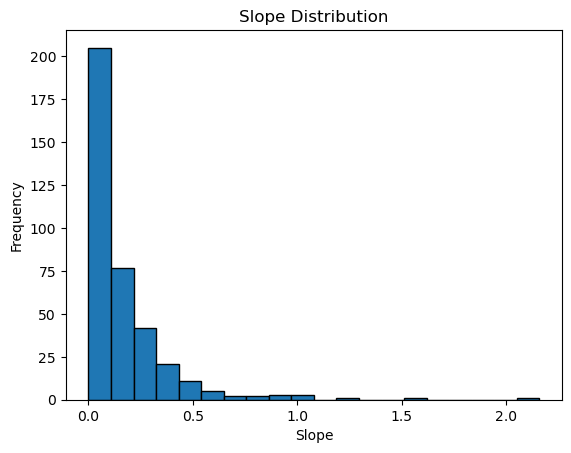

In [21]:
lakes_gdf['slope'].plot(kind='hist', bins=20, edgecolor='black', title='Slope Distribution')
plt.xlabel('Slope')
plt.ylabel('Frequency')
plt.show()


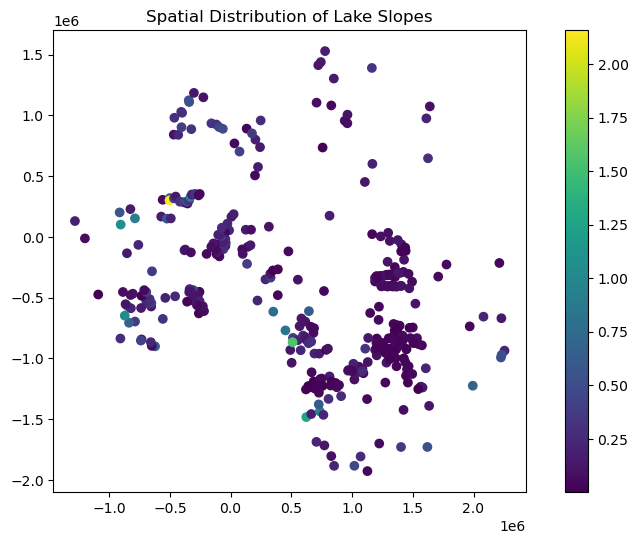

In [22]:
lakes_gdf.plot(column='slope', cmap='viridis', legend=True, figsize=(10, 6))
plt.title('Spatial Distribution of Lake Slopes')
plt.show()


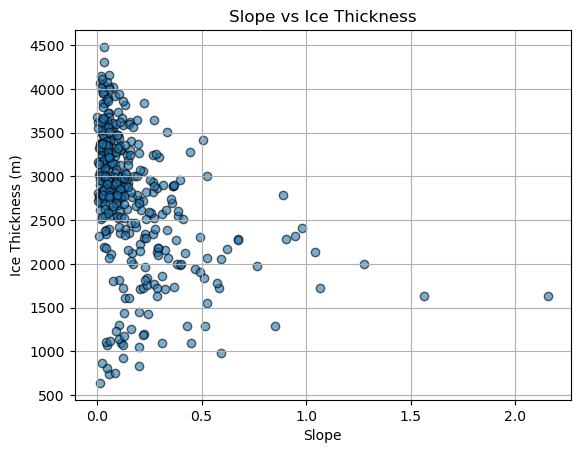

In [23]:
import matplotlib.pyplot as plt

plt.scatter(lakes_gdf['slope'], lakes_gdf['ice_thickness'], alpha=0.6, edgecolor='k')
plt.title('Slope vs Ice Thickness')
plt.xlabel('Slope')
plt.ylabel('Ice Thickness (m)')
plt.grid(True)
plt.show()


predictions

In [24]:
from sklearn.model_selection import train_test_split

# Drop rows with missing values
lakes_cleaned = lakes_gdf.dropna(subset=['slope', 'ice_thickness'])

# Define independent (X) and dependent (y) variables
X = lakes_cleaned[['slope']]
y = lakes_cleaned['ice_thickness']


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
from sklearn.linear_model import LinearRegression

# Create the model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)


LinearRegression()

In [27]:
y_pred = model.predict(X_test)


In [28]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate R²
r2 = r2_score(y_test, y_pred)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

print(f"R-squared: {r2:.3f}")
print(f"Mean Squared Error: {mse:.3f}")


R-squared: 0.156
Mean Squared Error: 619198.993


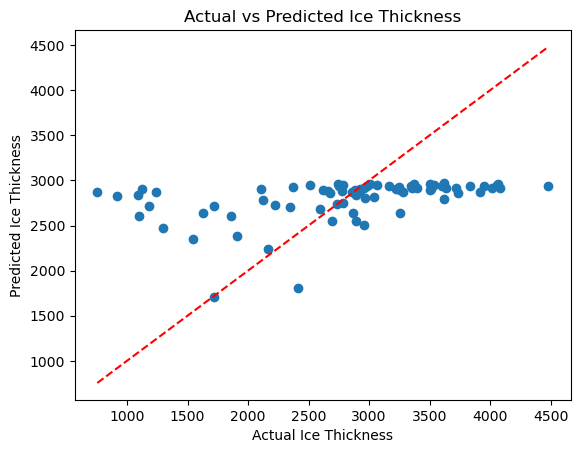

In [29]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Ice Thickness')
plt.ylabel('Predicted Ice Thickness')
plt.title('Actual vs Predicted Ice Thickness')
plt.show()


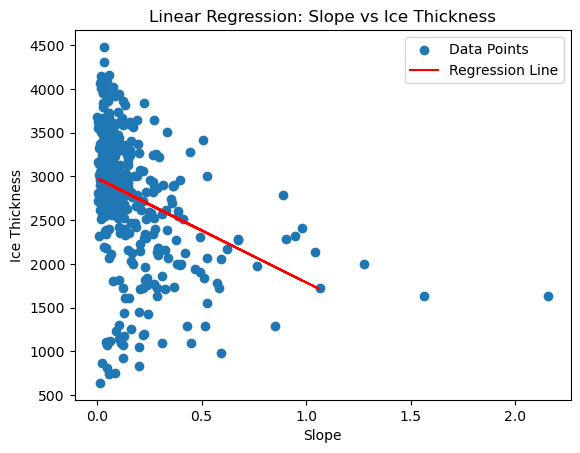

In [30]:
plt.scatter(X, y, label='Data Points')
plt.plot(X_test, model.predict(X_test), color='red', label='Regression Line')
plt.xlabel('Slope')
plt.ylabel('Ice Thickness')
plt.title('Linear Regression: Slope vs Ice Thickness')
plt.legend()
plt.show()


above stuff is kinda useless...

lets predict lake location

In [31]:
from sklearn.model_selection import train_test_split

# Drop rows with missing values for slope, latitude, and longitude
lakes_cleaned = lakes_gdf.dropna(subset=['slope', 'Latitude', 'Longitude'])

# Define independent (X) and dependent (y) variables for latitude and longitude prediction
X = lakes_cleaned[['slope']]
y_lat = lakes_cleaned['Latitude']
y_lon = lakes_cleaned['Longitude']


In [32]:
X_train, X_test, y_lat_train, y_lat_test, y_lon_train, y_lon_test = train_test_split(
    X, y_lat, y_lon, test_size=0.2, random_state=42)


In [33]:
from sklearn.linear_model import LinearRegression

# Create the model for latitude
model_lat = LinearRegression()

# Train the model for latitude
model_lat.fit(X_train, y_lat_train)

# Make predictions for latitude
y_lat_pred = model_lat.predict(X_test)


In [34]:
# Create the model for longitude
model_lon = LinearRegression()

# Train the model for longitude
model_lon.fit(X_train, y_lon_train)

# Make predictions for longitude
y_lon_pred = model_lon.predict(X_test)


In [35]:
from sklearn.metrics import mean_squared_error, r2_score

# Evaluate R-squared and MSE for latitude prediction
r2_lat = r2_score(y_lat_test, y_lat_pred)
mse_lat = mean_squared_error(y_lat_test, y_lat_pred)

print(f"Latitude Prediction R-squared: {r2_lat:.3f}")
print(f"Latitude Prediction MSE: {mse_lat:.3f}")


Latitude Prediction R-squared: 0.009
Latitude Prediction MSE: 25.051


In [36]:
# Evaluate R-squared and MSE for longitude prediction
r2_lon = r2_score(y_lon_test, y_lon_pred)
mse_lon = mean_squared_error(y_lon_test, y_lon_pred)

print(f"Longitude Prediction R-squared: {r2_lon:.3f}")
print(f"Longitude Prediction MSE: {mse_lon:.3f}")


Longitude Prediction R-squared: 0.076
Longitude Prediction MSE: 9838.676


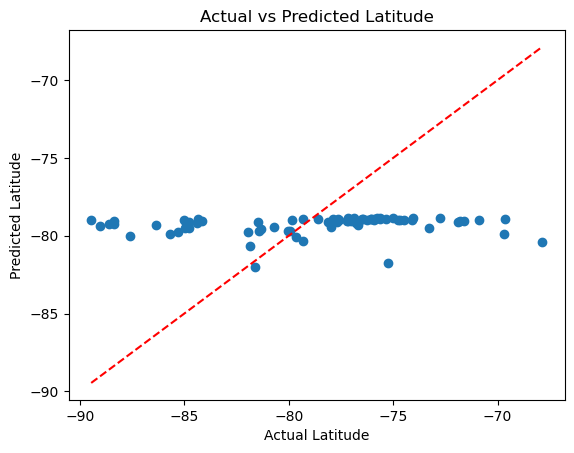

In [37]:
import matplotlib.pyplot as plt

plt.scatter(y_lat_test, y_lat_pred)
plt.plot([min(y_lat_test), max(y_lat_test)], [min(y_lat_test), max(y_lat_test)], color='red', linestyle='--')
plt.xlabel('Actual Latitude')
plt.ylabel('Predicted Latitude')
plt.title('Actual vs Predicted Latitude')
plt.show()


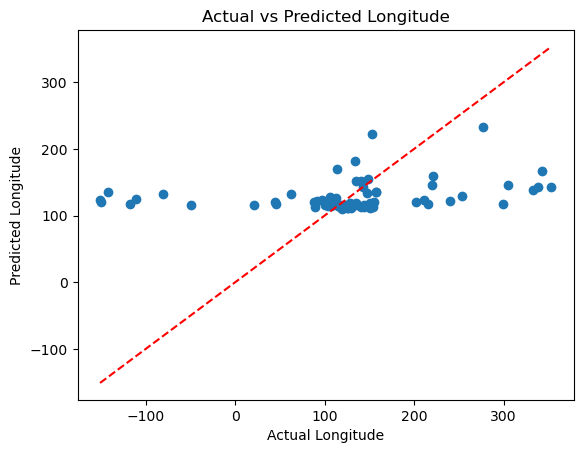

In [38]:
plt.scatter(y_lon_test, y_lon_pred)
plt.plot([min(y_lon_test), max(y_lon_test)], [min(y_lon_test), max(y_lon_test)], color='red', linestyle='--')
plt.xlabel('Actual Longitude')
plt.ylabel('Predicted Longitude')
plt.title('Actual vs Predicted Longitude')
plt.show()


this was also funny, slope doesn't matter...

raster tools is awesome

In [39]:
gdf_stats = zonal.zonal_stats(
    lakes_gdf, slp, list(zonal.ZONAL_STAT_FUNCS),
).compute()

c:\Users\aster\anaconda3\envs\rstools39\lib\site-packages\rasterio\features.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _rasterize(valid_shapes, out, transform, all_touched, merge_alg)


In [40]:
gdf_stats

band_1                                                                 \
     nunique  asm      prod      mean    median       sum var count entropy   
zone                                                                          
1          1  1.0  0.086016  0.086016  0.086016  0.086016 NaN     1     0.0   
2          1  1.0  0.114682  0.114682  0.114682  0.114682 NaN     1     0.0   
3          1  1.0  0.029392  0.029392  0.029392  0.029392 NaN     1     0.0   
4          1  1.0  0.227904  0.227904  0.227904  0.227904 NaN     1     0.0   
5          1  1.0  0.057291  0.057291  0.057291  0.057291 NaN     1     0.0   
...      ...  ...       ...       ...       ...       ...  ..   ...     ...   
375        1  1.0  0.095858  0.095858  0.095858  0.095858 NaN     1     0.0   
376        1  1.0  0.056701  0.056701  0.056701  0.056701 NaN     1     0.0   
377        1  1.0  0.229883  0.229883  0.229883  0.229883 NaN     1     0.0   
378        1  1.0  0.525441  0.525441  0.525441  0.525441 NaN     1     0.0   
379        1  1.0  0.516714  0.516714  0.516714  0.516714 NaN     1     0.0   

                                             
           min size std       max      mode  
zone                                         
1     0.086016    1 NaN  0.086016  0.086016  
2     0.114682    1 NaN  0.114682  0.114682  
3     0.029392    1 NaN  0.029392  0.029392  
4     0.227904    1 NaN  0.227904  0.227904  
5     0.057291    1 NaN  0.057291  0.057291  
...        ...  ...  ..       ...       ...  
375   0.095858    1 NaN  0.095858  0.095858  
376   0.056701    1 NaN  0.056701  0.056701  
377   0.229883    1 NaN  0.229883  0.229883  
378   0.525441    1 NaN  0.525441  0.525441  
379   0.516714    1 NaN  0.516714  0.516714  

[379 rows x 14 columns]

Extra

In [41]:
lakes_gdf

,Tally,Name,Latitude,Longitude,Length m,Width m,Depth m,Area km2,Volume km3,References,geometry,ice_thickness,slope
0,1,Sovetskaya Lake,-78.100,88.500,75000,35000.0,NaN,1600.0,NaN,Located beneath Sovetskaya Station. The first ...,POINT (1296999.561 33963.129),3919,0.086016
1,2,Lake Vostok,-78.150,104.500,280000,44000.0,1067.0,14000.0,5400.0,Included in the first inventory of Oswald and ...,POINT (1250803.318 -323479.733),3303,0.114682
2,3,SPRI-3,-76.570,124.800,5000,NaN,NaN,NaN,NaN,Oswald and Robin (1973),POINT (1203517.434 -836466.407),3474,0.029392
3,4,SPRI-4,-73.280,157.280,3500,NaN,NaN,NaN,NaN,Oswald and Robin (1973),POINT (706469.226 -1687214.515),2344,0.227904
4,5,SPRI-5,-77.200,119.270,10000,NaN,NaN,NaN,NaN,Oswald and Robin (1973),POINT (1218054.666 -682702.029),3729,0.057291
...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,375,R13Ea_8,-75.981,106.045,3500,NaN,NaN,NaN,NaN,Wright et al. (2012),POINT (1470914.122 -423028.361),3474,0.095858
375,376,R15Ea_4,-74.084,100.818,1800,NaN,NaN,NaN,NaN,Wright et al. (2012),POINT (1709145.571 -326593.471),3513,0.056701
376,377,Site A,-67.800,112.540,NaN,NaN,NaN,NaN,NaN,"N. Young (personal comm.), drained followed by...",POINT (2255000.417 -935896.682),1818,0.229883
377,378,Site B,-67.870,113.530,NaN,NaN,NaN,NaN,NaN,"N. Young (personal comm.), filling site, near ...",POINT (2231263.202 -971570.334),1549,0.525441


In [57]:
import json

# Convert to GeoJSON-compatible dictionary
geojson_dict = lakes_gdf.to_json()

# Write to a file
with open("lakes.geojson", "w") as f:
    f.write(geojson_dict)


In [56]:
print(lakes_gdf.dtypes)



Tally               int64
Name               object
Latitude          float64
Longitude         float64
Length   m         object
Width    m        float64
Depth m           float64
Area km2          float64
Volume km3        float64
References         object
geometry         geometry
ice_thickness       int64
slope             float64
coords             object
dtype: object
